In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import tensorflow as tf
import tensorflow_datasets as tfds
from nltk.corpus import wordnet as wn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import keract
from tqdm import tqdm
import pandas as pd
import seaborn as sns

from scipy import spatial


with_gpu = True
if not with_gpu:
    tf.config.experimental.set_visible_devices([], "GPU")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is Enabled")
else:
    print("GPU is not Enabled")
    
import vtk
from vtk.util import numpy_support

/home/insane/.cache/pypoetry/virtualenvs/apalysis-5kmHI_dQ-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


GPU is Enabled


In [3]:
MODEL, DATASET = 'vgg16', 'imagenette'
model = tf.keras.applications.vgg16.VGG16(
    weights='imagenet'
)
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
ds, info = tfds.load(
    'imagenette/320px-v2',
    shuffle_files=False,
    with_info=True,
    as_supervised=True,
    batch_size=None,
)
labels = tfds.features.ClassLabel(
    names=list(map(lambda l: wn.synset_from_pos_and_offset(
        l[0], int(l[1:])).name(), info.features['label'].names))
)
vgg16_input_shape = tf.keras.applications.vgg16.VGG16().input.shape[1:3].as_list()
@tf.function
def preprocess(x, y):
    x = tf.image.resize(x, vgg16_input_shape, method=tf.image.ResizeMethod.BILINEAR)
    x = tf.keras.applications.vgg16.preprocess_input(x)
    return x, y

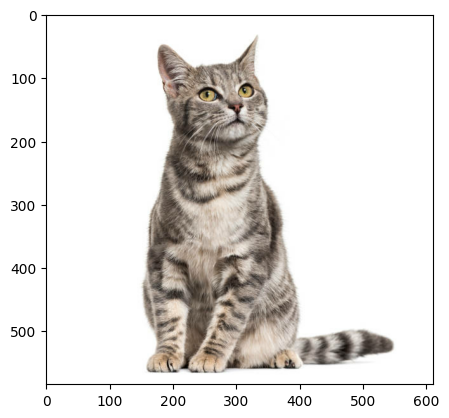

In [4]:
# load the image cat.jpg
img = tf.io.read_file("cat.jpg")
raw_img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(raw_img, tf.float32)
img = tf.image.resize(img, vgg16_input_shape, method=tf.image.ResizeMethod.BILINEAR)
img = tf.keras.applications.vgg16.preprocess_input(img)
img = tf.expand_dims(img, axis=0)
img = tf.Variable(img)

# draw the image
plt.imshow(raw_img)
plt.show()

In [5]:
# get the activations using keract
activations = keract.get_activations(model, img)

# get the activations of the last CNN layer
last_cnn_layer = model.get_layer("block5_conv3")
last_cnn_activations = activations[last_cnn_layer.name][0]

last_cnn_activations.shape

(14, 14, 512)

In [6]:
# save the activation as vtk
VTK_data = numpy_support.numpy_to_vtk(num_array=last_cnn_activations.ravel(), deep=True, array_type=vtk.VTK_FLOAT)

# save VTK_data as a VTK file
writer = vtk.vtkXMLImageDataWriter()
imageData = vtk.vtkImageData()
imageData.SetDimensions(last_cnn_activations.shape)
imageData.GetPointData().SetScalars(VTK_data)
writer.SetFileName("activations.vti")
writer.SetInputData(imageData)
writer.Write()


1

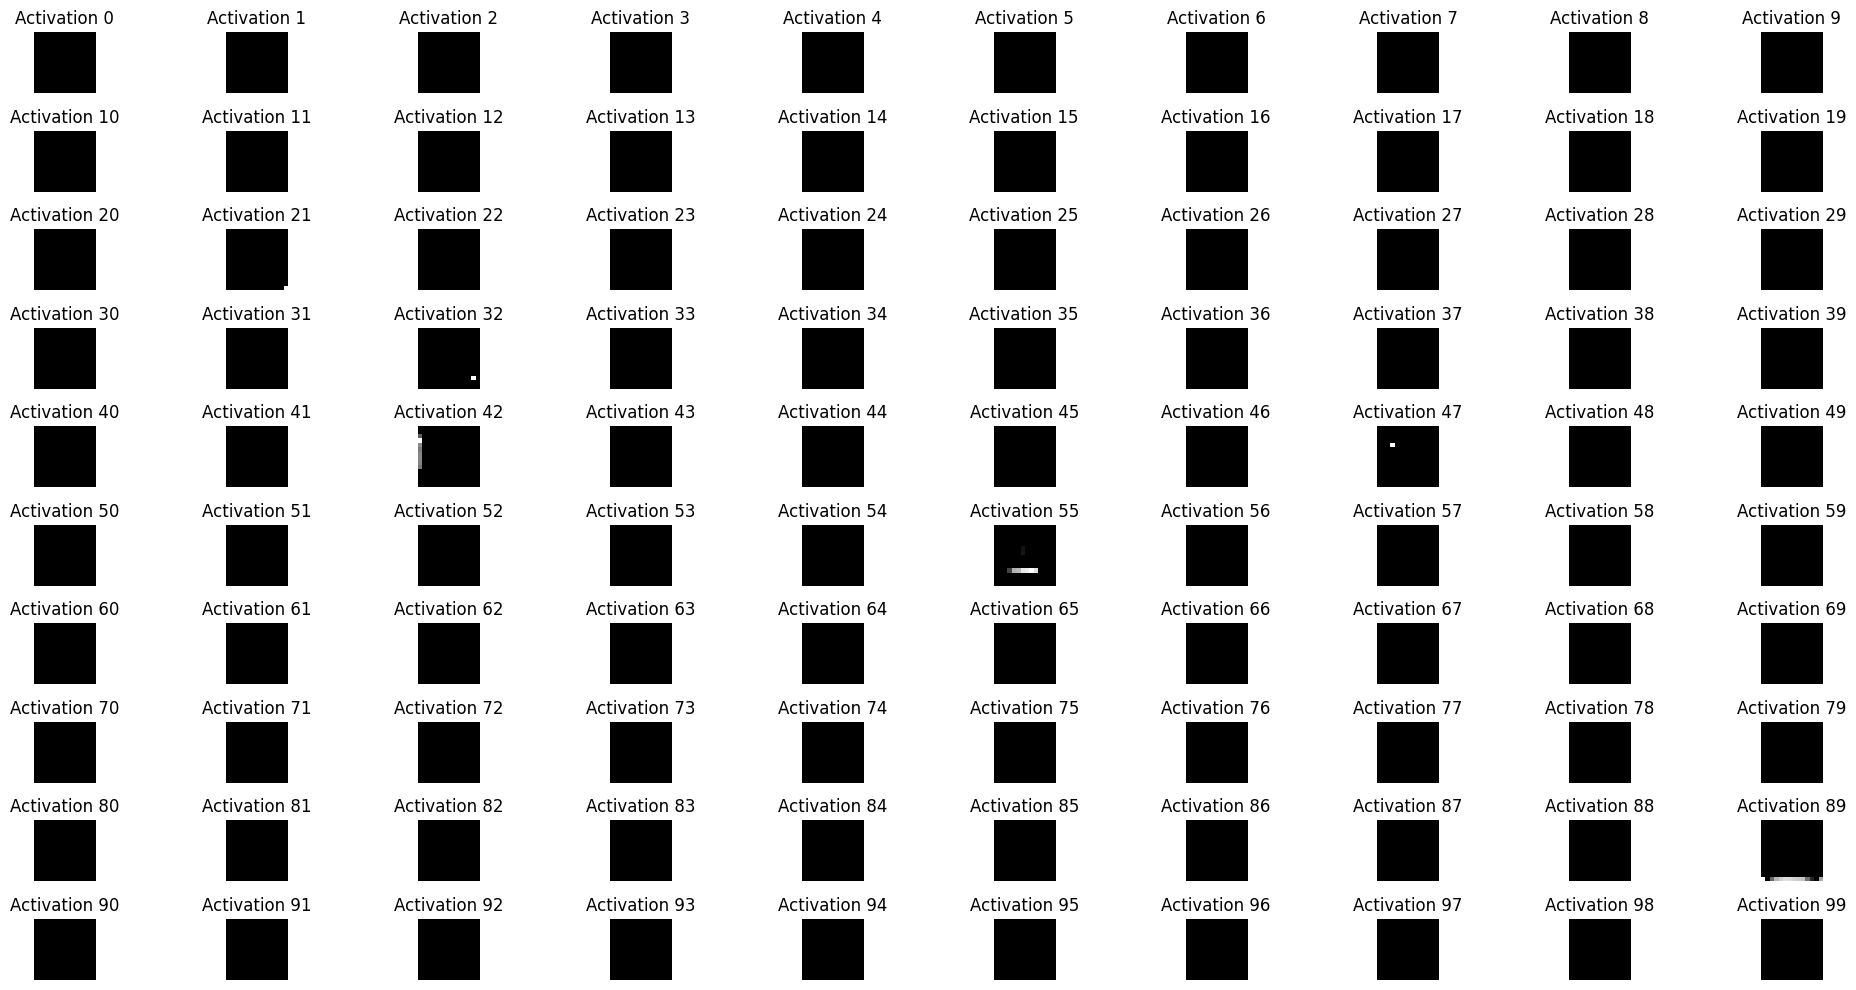

In [7]:
# draw the first 10 activations
start = 0
rows = 10
cols = 10
fig, axs = plt.subplots(rows, cols, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    # rescale the activations to be between 0 and 1
    act_min = np.min(last_cnn_activations[:, :, i+start])
    act_max = np.max(last_cnn_activations[:, :, i+start])
    if act_max == act_min:
        rescaled_activations = np.zeros_like(last_cnn_activations[:, :, i+start])
    else:
        rescaled_activations = (last_cnn_activations[:, :, i+start] - act_min) / (act_max - act_min)
    ax.imshow(rescaled_activations, cmap="gray")
    ax.axis("off")
    ax.set_title(f"Activation {i}")
plt.tight_layout()
plt.show()

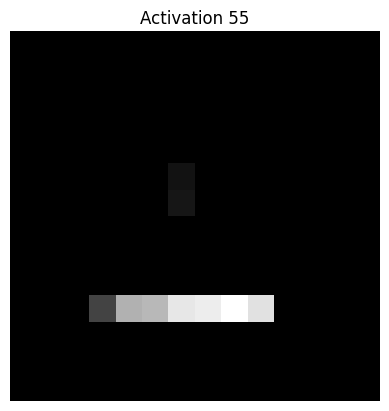

In [23]:
# draw ith activation
i = 55
plt.imshow(last_cnn_activations[:, :, i], cmap="gray")
plt.axis("off")
plt.title(f"Activation {i}")
plt.show()

In [8]:
last_cnn_activations.shape

(14, 14, 512)